In [1]:
#pip install -q tflite-model-maker

import os

import numpy as np

import tensorflow as tf
assert tf.__version__.startswith('2')

from tflite_model_maker import model_spec
from tflite_model_maker import image_classifier
from tflite_model_maker.config import ExportFormat
from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.image_classifier import DataLoader

import matplotlib.pyplot as plt

C:\Users\Techatach\anaconda3\envs\myenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
image_path = 'train'

In [3]:
data = DataLoader.from_folder(image_path)

INFO:tensorflow:Load image with size: 5656, num_label: 5, labels: cbb, cbsd, cgm, cmd, healthy.


##### Split it to training data (80%), validation data (10%, optional) and testing data (10%).

In [4]:
train_data, rest_data = data.split(0.8)
validation_data, test_data = rest_data.split(0.5)

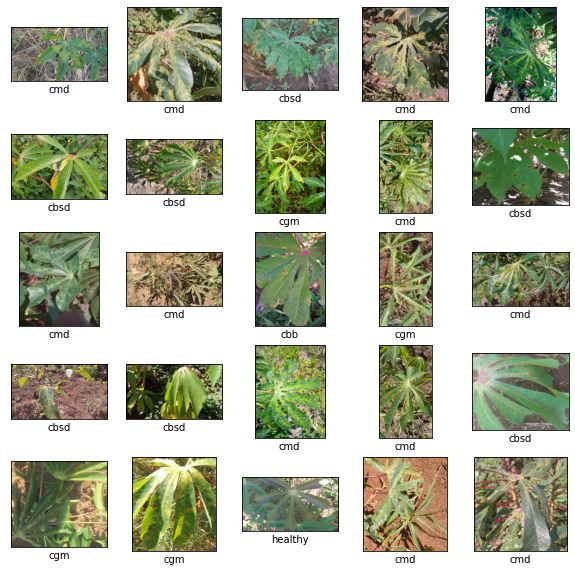

In [5]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(data.gen_dataset().unbatch().take(25)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)
  plt.xlabel(data.index_to_label[label.numpy()])
plt.show()

In [6]:
model = image_classifier.create(train_data, validation_data=validation_data, 
                                epochs=2) #, batch_size=64, shuffle=True)

INFO:tensorflow:Retraining the models...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2 (HubKe  (None, 1280)             3413024   
 rasLayerV1V2)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 3,419,429
Trainable params: 6,405
Non-trainable params: 3,413,024
_________________________________________________________________
None


C:\Users\Techatach\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/2
141/141 [==============================] - 125s 880ms/step - loss: 1.1188 - accuracy: 0.6370 - val_loss: 0.9517 - val_accuracy: 0.7226
Epoch 2/2
141/141 [==============================] - 123s 871ms/step - loss: 0.9847 - accuracy: 0.7043 - val_loss: 0.9243 - val_accuracy: 0.7456


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2 (HubKe  (None, 1280)             3413024   
 rasLayerV1V2)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 3,419,429
Trainable params: 6,405
Non-trainable params: 3,413,024
_________________________________________________________________


In [8]:
loss, accuracy = model.evaluate(test_data)

print('ค่า Loss = {:.3f}'.format(loss))
print('ค่า Accuracy = {:.3f}'.format(accuracy))

18/18 [==============================] - 18s 715ms/step - loss: 0.9300 - accuracy: 0.7102
ค่า Loss = 0.930
ค่า Accuracy = 0.710


##### Plot รูปออกมาพยากรณ์ สีแดงคือ พยากรณ์ผิด ส่วนสีดำคือ พยากรณ์ถูก

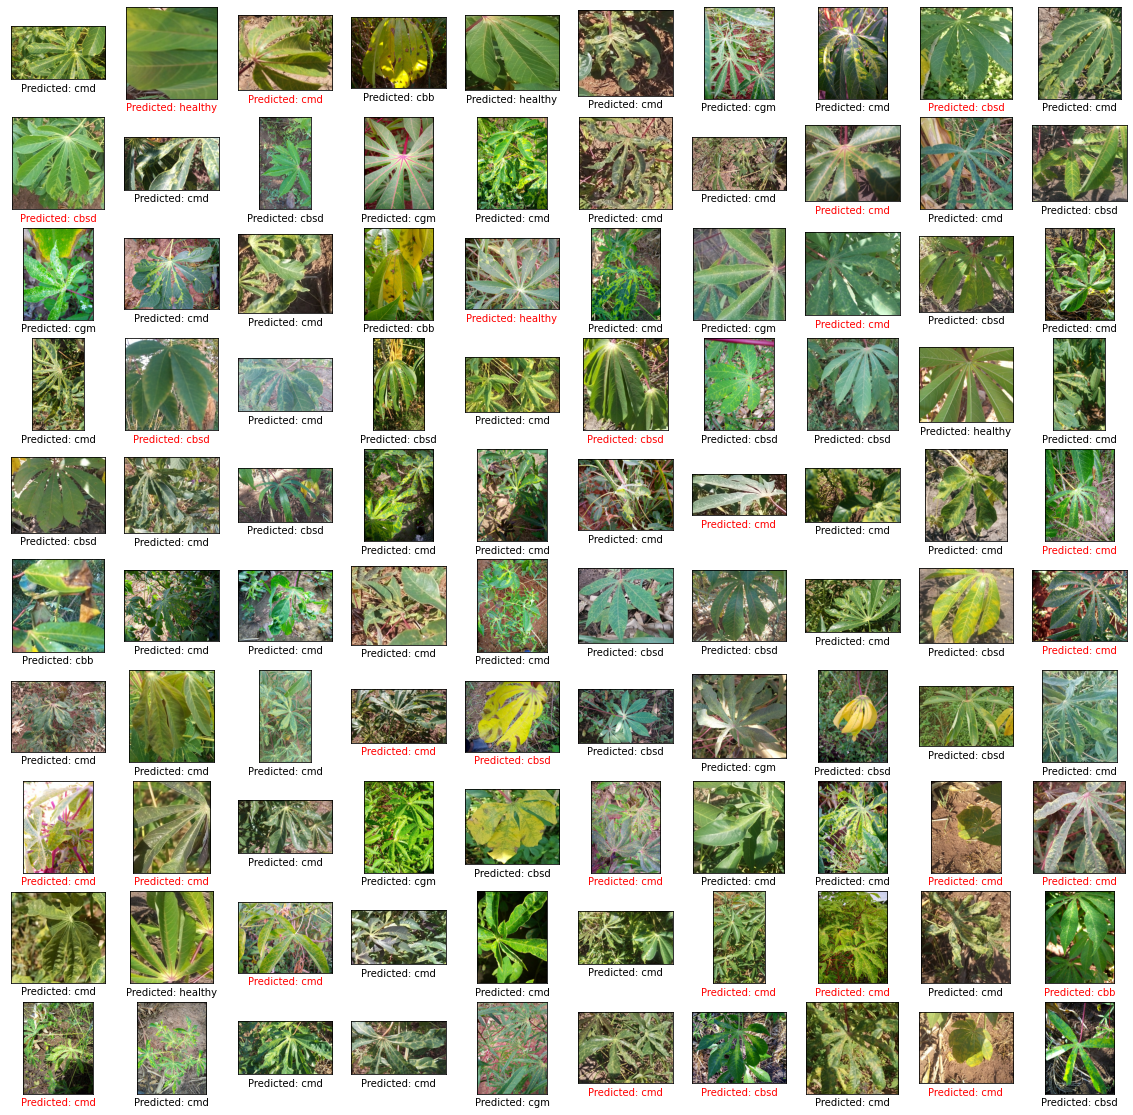

In [9]:
# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Then plot 100 test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(20, 20))
predicts = model.predict_top_k(test_data)
for i, (image, label) in enumerate(test_data.gen_dataset().unbatch().take(100)):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)

  predict_label = predicts[i][0][0]
  color = get_label_color(predict_label,
                          test_data.index_to_label[label.numpy()])
  ax.xaxis.label.set_color(color)
  plt.xlabel('Predicted: %s' % predict_label)
plt.show()

##### Export to TensorFlow Lite Model

In [10]:
model.export(export_dir='.')

INFO:tensorflow:Assets written to: C:\Users\TECHAT~1\AppData\Local\Temp\tmpcvk6zqy4\assets


INFO:tensorflow:Assets written to: C:\Users\TECHAT~1\AppData\Local\Temp\tmpcvk6zqy4\assets


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in C:\Users\TECHAT~1\AppData\Local\Temp\tmpmp05dcgt\labels.txt


INFO:tensorflow:Saving labels in C:\Users\TECHAT~1\AppData\Local\Temp\tmpmp05dcgt\labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: .\model.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: .\model.tflite


In [11]:
model.export(export_dir='.', export_format=ExportFormat.LABEL)

INFO:tensorflow:Saving labels in .\labels.txt


INFO:tensorflow:Saving labels in .\labels.txt


In [12]:
model.evaluate_tflite('model.tflite', test_data)

{'accuracy': 0.7067137809187279}